In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -d . drive/MyDrive/data.zip

Archive:  drive/MyDrive/data.zip
  inflating: ./lenta_sample.csv      
  inflating: ./__MACOSX/._lenta_sample.csv  


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv("lenta_sample.csv")
data.dropna(subset = ['topic', 'text'], inplace=True)

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [7]:
vocab = Counter()
for text in data["text"]:
    vocab.update(preprocess(text))

In [8]:
filtered_vocab = set()
for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [9]:
word2id = {"PAD":0}
for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, word2id, MAX_LEN, texts, targets):
        super().__init__()
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        self.target = torch.LongTensor(targets)
        
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN

#         self.target = self.target[self.texts.sum(1).bool()]
#         self.texts = self.texts[self.texts.sum(1).bool()]
        self.length = len(texts)
        
    def __getitem__(self, item):
        ids = self.texts[item]
        y = self.target[item]
        return ids, y
    
    def __len__(self):
        return self.length
    
    @staticmethod
    def preprocess(text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens        

In [11]:
MAX_LEN = 200

In [12]:
texts = data["text"].values
id2label = {i:l for i, l in enumerate(set(data.topic))}
label2id = {l:i for i, l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [13]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [14]:
training_set:torch.utils.data.Dataset = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator:torch.utils.data.DataLoader = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True)

In [15]:
valid_set:torch.utils.data.Dataset = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator:torch.utils.data.DataLoader = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True) 

In [16]:
from sklearn.metrics import f1_score

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
import math

In [20]:
class Clf(nn.Module):
    def __init__(self, output_dim, word2id=word2id):
        super().__init__()
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.MAX_LEN
        
        self.KERNEL_SIZE_1 = 3
        self.OUT_CHANNELS_1 = 64
        self.KERNEL_SIZE_2 = 5
        self.OUT_CHANNELS_2 = 32
        self.KERNEL_SIZE_POOL = 2
        self.STRIDE = 2
        self.STRIDE_POOL = 2
        self.RNN_UNITS = 128
        self.HIDDEN_FC = 64
        
        self.conv_size_1 = math.floor(((self.EMB_DIM - 1 * (self.KERNEL_SIZE_1 - 1) - 1) / self.STRIDE) + 1)
        self.pool_size_1 = math.floor(((self.conv_size_1 - 1 * (self.KERNEL_SIZE_POOL - 1) - 1) / self.STRIDE_POOL + 1))
        self.con_size_2 = math.floor(((self.pool_size_1 - 1 * (self.KERNEL_SIZE_2 - 1) - 1) / self.STRIDE) + 1)
        self.pool_size_2 = math.floor(((self.con_size_2 - 1 * (self.KERNEL_SIZE_POOL - 1) / self.STRIDE_POOL) + 1))
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.conv_1 = nn.Conv1d(self.IN_CHANNELS,
                                self.OUT_CHANNELS_1,
                                self.KERNEL_SIZE_1,
                                self.STRIDE)
        self.pool_1 = nn.MaxPool1d(self.KERNEL_SIZE_POOL,
                                   self.STRIDE_POOL)
        self.conv_2 = nn.Conv1d(self.OUT_CHANNELS_1,
                                self.OUT_CHANNELS_2,
                                self.KERNEL_SIZE_2,
                                self.STRIDE)
        self.pool_2 = nn.MaxPool1d(self.KERNEL_SIZE_POOL,
                                   self.STRIDE_POOL)
        self.relu = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout(0.3)
        
#         self.lstm = nn.LSTM(self.pool_size_2, self.RNN_UNITS, batch_first=True)
#         self.gru = nn.GRU(self.pool_size_2, self.RNN_UNITS, batch_first=True)
        self.lstm = nn.LSTM(self.OUT_CHANNELS_2, self.RNN_UNITS, batch_first=True)
        self.gru = nn.GRU(self.OUT_CHANNELS_2, self.RNN_UNITS, batch_first=True)
        
        
        self.fc = nn.Linear(self.RNN_UNITS, self.HIDDEN_FC)
        self.hidden = nn.Linear(self.HIDDEN_FC, output_dim)        
        self.act = nn.LogSoftmax(1)

    def forward(self, text):
#         embedded = self.embedding(text).permute(0, 2, 1)
        embedded = self.embedding(text)
        conv1 = self.relu(self.conv_1(embedded))
        pool1 = self.pool_1(conv1)
        conv2 = self.relu(self.conv_2(pool1))
        pool2 = self.pool_2(conv2).permute(0, 2, 1)
        pool_backward = torch.flip(pool2, (1,))
        
        gru_out, (h, *_) = self.gru(pool2)
        lstm_out, (h_b, *_) = self.lstm(pool_backward)
        h, h_b = h.squeeze(0).unsqueeze(dim=2), h_b.squeeze(0).unsqueeze(dim=2)
        cat = torch.cat((h, h_b), dim=2)
        mean = torch.mean(cat, dim=2).float()
        fc = self.dropout(self.fc(mean))        
        hidden = self.hidden(fc)
        out = self.act(hidden)
        return out
    
model:torch.nn.Module = Clf(len(label2id))
optimizer:torch.optim.Optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss().to(device)
model = model.to(device)

In [21]:
def train(model:nn.Module,
          iterator:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:nn.modules.loss._Loss,
          print_every:int=1000):
    epoch_loss:list = []
    epoch_f1:list = []
    model.train()
    
    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = loss_fn(predictions, ys.to(device))
        
        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i + 1) % print_every:
            print(f"loss: {np.mean(epoch_loss)}; F1: {np.mean(epoch_f1)}")
    return np.mean(epoch_f1)
    
def evaluate(model:nn.Module,
             iterator:torch.utils.data.DataLoader,
             loss_fn:torch.nn.modules.loss._Loss):
    epoch_loss:list = []
    epoch_f1:list = []
        
    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            loss = loss_fn(predictions, ys.to(device))
            preds = predictions.detach().to("cpu").numpy().argmax(1).tolist()
            y_true = ys.tolist()
            
            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
    return np.mean(epoch_f1)

In [22]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion))
    ev = evaluate(model, valid_generator, criterion)
    print("Eval - ", ev)
    f1s_eval.append(ev)

0
Eval -  0.5893163314176245
1
Eval -  0.7021276340996169
2
Eval -  0.7459650383141763
3
Eval -  0.7552448515325672
4
Eval -  0.7683387212643678
5
Eval -  0.7661368534482759
6
Eval -  0.7659602490421457
7
Eval -  0.7683105842911878
8
Eval -  0.7619103208812261
9
Eval -  0.7577717911877394


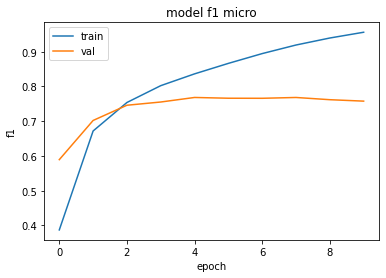

In [23]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()